<a href="https://colab.research.google.com/github/Nguyen-The-Thanh/NguyenTheThanh_training_FMlab/blob/main/Ex/Ex11/convolutional_network_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Bài tâp về mạng tích chập

Trong bài này, chúng ta sẽ xây dựng một mạng tích chập sử dụng Torch và thử train&Test tập MNIST nhé.


## Tổng quan một mạng CNN cơ bản

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST dataset

Trong bài tập này, chúng ta sẽ sử dựng tập MNIST rất nổi tiếng vể  các chữ số viết tay từ 0->9. Tập dataset này bao gồm 60000 ảnh cho training và 10000 ảnh cho testing. Các bức ảnh này đều đã được căn giữa và chỉnh với kích thước cố định là 28x28.

Trong phần tiền xử lý, chúng ta sẽ cần chuẩn hóa các giá trị pixel của mỗi ảnh về khoảng [0,1], kiểu dữ liệu sẽ là float32

<!-- ![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png) -->

Chi tiết tại: http://yann.lecun.com/exdb/mnist/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

# Some configs

In [2]:
# Số classes trong tập MNIST
num_classes = 10

# Số epoch
epochs = 3

# Các tham số cần thiết cho quá trình traning.
learning_rate = 0.001
batch_size = 128
display_step = 100

# Tham số mạng CNN
out_channel_1  = 32 # số channel của đầu ra conv thứ 1
out_channel_2 = 64 # số channel của đầu ra conv thứ 2

# Path lưu best model
checkpoint = 'model.pth'

# Dataloader

In [3]:
# Transform image
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# load dataset từ torchvision.datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('../data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.82MB/s]


# Model

- Input shape sẽ là: [-1, 28, 28, 1]. Ở đây -1 sẽ thể hiện batchsize, một batch thì gồm nhiều ảnh 28x28x1 (grayscale, số channel là 1 !)
- Chúng ta sẽ định nghĩa một model đơn giản gồm 2 lớp Conv đều có filter size là 3x3 và stride hãy set là 1.
- Ngoài ra sẽ có một lớp maxpool, set filter size 2x2
- Flow như sau: conv2d_1 -> relu -> conv2d_2 -> relu -> maxpool2d -> dropout -> flatten -> linear1 -> relu -> dropout -> linear2


In [5]:
# Định nghĩa model

model = nn.Sequential (
    nn.Conv2d(1, out_channel_1, 3, 1),
    nn.ReLU() ,
    nn.Conv2d(out_channel_1, out_channel_2, 3, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(9216, 64),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(64, num_classes)
)

# load lại pretrained model (nếu có)
try:
  model.load_state_dict(torch.load(checkpoint))
except:
  print("!!! Hãy train để có checkpoint file")

!!! Hãy train để có checkpoint file


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = 999

for epoch in range(1,epochs):
    # Quá trình training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # Quá trình testing
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            output = F.log_softmax(output, dim = 1) # log softmax using F
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True) # argmax để lấy predicted label, chú ý keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint) # Lưu lại model
      print("***********    TEST_ACC = {}%    ***********".format(correct))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.304930
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.264329
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.240460
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.209125
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.215327
***********    TEST_ACC = 9794%    ***********
Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.168035
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.059456
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.100616
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.137497
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.206318
***********    TEST_ACC = 9833%    ***********


# Visualize Image

In [7]:
# load lại model đã train
model.load_state_dict(torch.load(checkpoint))
# set eval phase
model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.3, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=9216, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.4, inplace=False)
  (10): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
item = iter(test_loader)

In [10]:
data,target = item.__next__() # lấy một batch ra

In [11]:
test_idx = random.choice(range(len(data))) # lấy index của một phần tử của một batch

In [12]:
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1,28,28)

In [13]:
# thử predict

def plot(data,model):
  data = torch.unsqueeze(data, dim=0) # unsqueeze data
  output = model(data)
  output = F.log_softmax(output, dim=1) # log softmax, chú ý dim
  pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim
  print("Predict Number : ", pred[0][0].numpy())
  plt.imshow(data[0][0],cmap='gray')
  plt.show()

Predict Number :  7


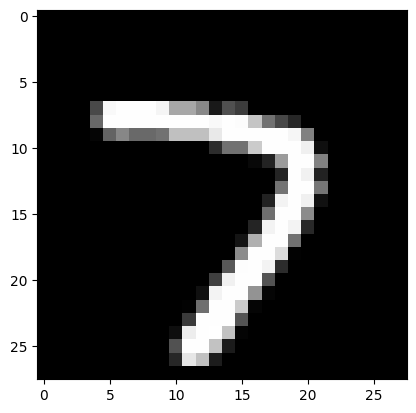

In [14]:
plot(data,model)